# Исследование по определению закономерностей влияющих на популярность компьютерных игр.

**Цель**-выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**План** 

1. Открыть файл с данными и оценить общую информацию.
2. Исправить ошибки в данных:
    1. привести к нижнему регистру,
    2. преобразовать в нужные типы,
    3. обработать пропуски,
    4. посчитать суммарные продажы по каждому региону и сохранить в отдельный столбец.
3. Провести исследовательский анализ:
    1. посмотреть как изменялись продажи по разным платформам,
    2. выбрать данные за актуальный период,
    3. выбрать потенциально прибыльные платформы,
    4. определить как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков,
    5. Соотнести выводы с продажами игр на других платформах,
    6. Определить общее распределение игр по жанрам, выявить самые прибыльные жанры.
4. Составить портрет пользователя каждого региона:
    1. ТОП-5 самых популярных платформ,
    2. ТОП-5 самых популярных жанров,
    3. определить влияет ли рейтинг ESRB на продажи в отдельном регионе.
5. Проверить гипотезы:
    1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые,
    2. Средние пользовательские рейтинги жанров Action и Sports разные.
6. Сделать общий вывод. 

## Открытие файла с данными и изучение общей информации. 

In [1]:
!pip install pandas_profiling -U

Requirement already up-to-date: pandas_profiling in c:\users\nataly\anaconda3\lib\site-packages (2.11.0)


In [2]:
import pandas as pd
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.gofplots import qqplot
from scipy import stats as st

In [3]:
df=pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
display(df.head())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
#pandas_profiling.ProfileReport(df, minimal=True)

посмотрим количество игр с tbd по годам выпуска 

In [6]:
tbd_df=df.loc[df['User_Score']=='tbd']
tbd_df.groupby('Year_of_Release').agg({'User_Score':'count'})

,User_Score
Year_of_Release,
1997.0,1
1999.0,8
2000.0,43
2001.0,82
2002.0,192
2003.0,95
2004.0,107
2005.0,121
2006.0,124


tbd встречается в играх разных годов, значит это те игры которым по каким-то причинам (возможно из-за низкой популярности не дали ни 1 оценки)

### Промежуточный вывод

- надо привести названия к нижнему регистру,
- столбец Year_of_Release надо перевесть в тип int,
- User_Score в float,
- в столбце User_Score много значений равных tbd - сокращение от To Be Determined ("будет определено"), используется для определения пропусков, которые надо заполниить. вероятно возникли в играх у котроых нет не одного проголосовавшего пользователя. чтобы можно было перевести в тип float, заполним медианами по жанру.
- пропуски в столбцах Critic_Score (51,3%), User_Score (40,1%) не стоит заполнять, т.к. пропущенных значений слишком много и они будут влиять на корреляцию.
- пропуски в столбце Year_of_Release удалим, т.к. их очень мало (1,6%) и на результаты не сильно повлияют, а восстановить их трудно.
- пропуски в Rating (40,5%) заменим на RP (рейтинг ожидается).
- 2 строки с пропущeнными названиями и жанрами надо удалить, т.к. название не восстановить и таких строк очень мало.
- много нулевых значений в столбцах с продажами. скорее всего из-за того, что продаж было мало, а в таблице они измеряются в млн. удалять нельзя.

## Предобработка данных

### перевод названий в нижний регистр

In [7]:
df.columns = df.columns.str.lower()
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### обработка пропусков

удалим пропуски в жанрах и названиях т.к. их всего 2 и в году выпуска т.к их 1,6%

In [8]:
df.dropna(subset=['year_of_release'], inplace=True, axis=0)
df['year_of_release'].isna().sum()

df.dropna(subset=['genre'], inplace=True, axis=0)
df.dropna(subset=['name'], inplace=True, axis=0)

пропуски в столбце с рейтингом заполним значением "RP" (рейтинг ожидается)

In [9]:
df.loc[df['rating'].isna(), 'rating']= 'RP'
df['rating'].isna().sum()

0

в пользовательском рейтинге заменим tbd на NaN т.к. они не отличаются по смыслу 

In [10]:
df['user_score']=df['user_score'].str.replace('tbd', '')
df.loc[df['user_score']=='tbd', 'user_score'].count()

0

### преобразование типов данных

In [11]:
df['year_of_release']=df['year_of_release'].astype('uint16')
df['user_score']=pd.to_numeric(df['user_score'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  uint16 
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), object(4), uint16(1)
memory usage: 1.4+ MB


### подсчет суммарных продаж по регионам

In [12]:
df['total_sales']=df['na_sales']+df['eu_sales']+df['jp_sales']+df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,RP,31.38


### промежуточный вывод

- заголовки переведны в нижний регистр.
- удалены пропуски с названем, годом выпуска и жанром, т.к. их было очень мало.
- tbd в пользовательском рейтинге заменены на NaN.
- пропуски в рейтинге заполнены "RP" (рейтинг ожидается).
- год релиза переведен в тип uint, пользовательский рейтинг в тип float.
- посчитаны продажи каждой игры по всем регионам и сохранено в столбец total_sales.

## Исследовательский анализ

### определение актуального периода

составим рапределение выпуска игр по годам

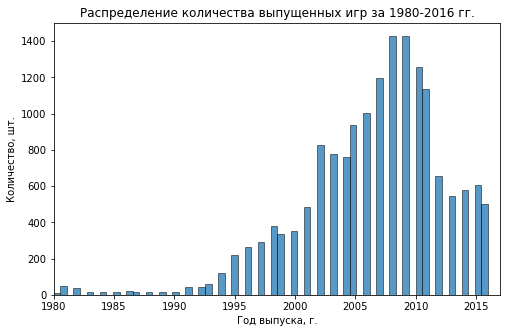

In [13]:
f, ax = plt.subplots(figsize=(8, 5))
sns.histplot(df, x='year_of_release', linewidth=.5)
plt.xlim(1980, 2017)
plt.ylim(0, 1500)
plt.xlabel('Год выпуска, г.')
plt.ylabel('Количество, шт.')
plt.title('Распределение количества выпущенных игр за 1980-2016 гг.')
plt.show()

изучим изменения продаж по платформам.

создадим таблицу с играми с наибольшими продажами

In [14]:
platforms_max=df.groupby(['platform']).agg({'total_sales':'sum'}).sort_values(by='total_sales', ascending=False)
top=platforms_max.loc[platforms_max['total_sales']>=300].index
top

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA'], dtype='object', name='platform')

In [15]:
pivot_platforms=df.pivot_table(index='platform', 
                                          columns='year_of_release', 
                                          values='total_sales', 
                                          aggfunc='sum')
pivot_platforms = pivot_platforms.rename(columns={'year_of_release':''})
top_platforms=pivot_platforms.query('platform in @top')
top_platforms

year_of_release,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,
DS,NaN,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,...,146.94,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN
GBA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PS2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,75.99,53.90,26.40,5.64,0.45,NaN,NaN,NaN,NaN,NaN
PS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60
PS4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.99,100.00,118.90,69.25
Wii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18
X360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95.41,135.26,120.29,170.03,143.84,99.74,88.58,34.74,11.96,1.52


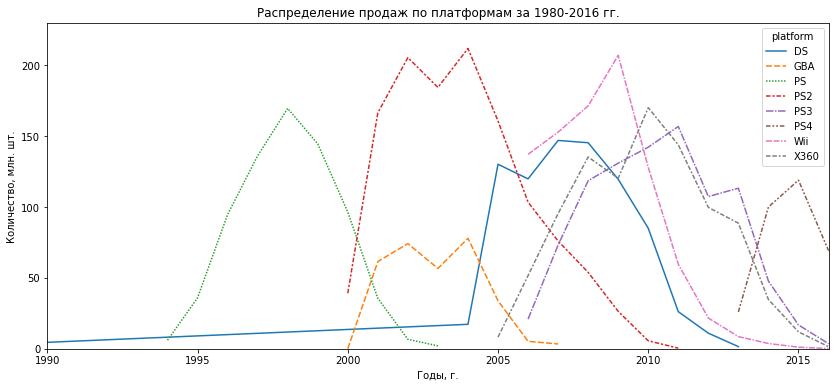

In [49]:
top_platforms=top_platforms.transpose()  # транспонируем таблицу чтобы проще построить график
f, ax=plt.subplots(figsize=(14, 6))
sns.lineplot(data=top_platforms)
plt.xlim(1990, 2016)
plt.ylim(0, 230)
plt.xlabel('Годы, г.')
plt.ylabel('Количество, млн. шт.')
plt.title('Распределение продаж по платформам за 1980-2016 гг.')
plt.show()

данные ранее 2011 г. бесполезны, т.к. большинство платформ используются ~ 10 лет и тренд меняется в среднем в середине срока использования (через 5 лет) => в исследовании будем использовать данные за последние 5 лет. в среднем, каждые 5 лет появляется новая платформа.

создадим новую таблицу с данными с 2011 года.

In [17]:
new_df=df.query('year_of_release>=2011')
#new_df.head()

### определение платформ-лидеров

создадим сводную таблицу по году выпуска игры, названию платформы и объемам продаж

In [18]:
platforms_2011=new_df.pivot_table(index='year_of_release', 
                                          columns='platform', 
                                          values='total_sales', 
                                          aggfunc='sum')
platforms_2011

platform,3DS,DS,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,,
2011,63.20,26.18,35.03,0.45,156.78,NaN,17.82,4.63,59.65,NaN,143.84,NaN
2012,51.36,11.01,23.22,NaN,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,NaN,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,NaN,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,NaN,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,NaN,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


построим распределение прожад по платформам

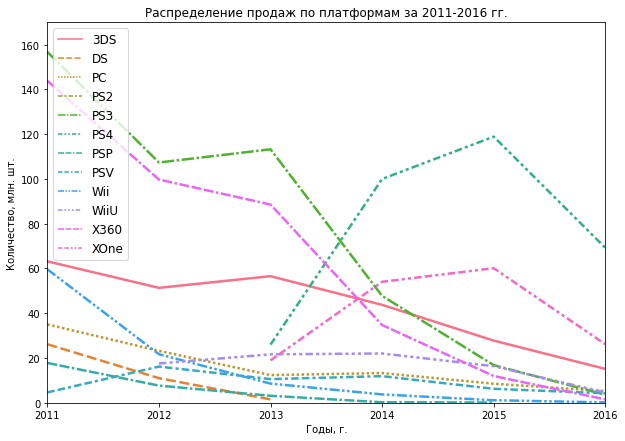

In [19]:
f, ax=plt.subplots(figsize=(10, 7))
sns.lineplot(data=platforms_2011, linewidth =2.5)
plt.xlim(2011, 2016)
plt.ylim(0, 170)
plt.xlabel('Годы, г.')
plt.ylabel('Количество, млн. шт.')
plt.title('Распределение продаж по платформам за 2011-2016 гг.')
plt.legend(loc='upper left', fontsize='large')
plt.show()

продажи растут только по платформам PS4 и XOne, по остальным происходит сокращение продаж за последние 5 лет. особенно интенсивное сокращение по PS3, X360, 3DS. 

опеределим лидеров по продажам за последние 5 лет

In [20]:
top_2011=new_df.groupby(['platform']).agg({'total_sales':'sum'}).sort_values(by='total_sales', ascending=False)
top_2011=top_2011.loc[top_2011['total_sales']>=80]
top_2011

,total_sales
platform,
PS3,445.57
X360,380.38
PS4,314.14
3DS,257.81
XOne,159.32
PC,97.68
Wii,95.02
WiiU,82.19


- *лидеры продаж* за последние 5 лет: PS3, X360, PS4, 3DS, XOne.
- *потенциально прибыльными* являются платформы *PS4 и XOne*, они - новые поколения самых прибых за последие 5 лет платформ, и продажи по ним растут.

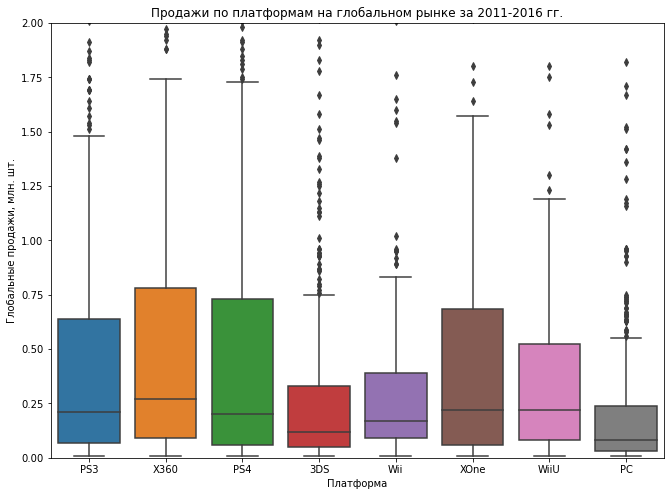

In [21]:
best_platforms=new_df.query('platform in @top_2011.index')
f, ax=plt.subplots(figsize=(11, 8))
sns.boxplot(data=best_platforms, x='platform', y='total_sales')
plt.ylim(0, 2)
plt.xlabel('Платформа')
plt.ylabel('Глобальные продажи, млн. шт.')
plt.title('Продажи по платформам на глобальном рынке за 2011-2016 гг.')
plt.show()

- самые большие продажи имеют платформы X360, PS3, PS4 и XOne. остальные очень заметно отстают. 
- Xbox платформы превышают по медианному объему PS платформы, однако если PS3 уступает X360 по объему продаж, то PS4 немного превосходит XOne и даже конкурирует с X360.
- присутствует значительное число выбросов, особенно по платформам 3DS, что может быть обусловленно выходом какой-нибудь популярной игры. 

### определение влияния отзывов на продажи

создадим датасет с данными только по PS4, (т.к. она выбрана одной из потенциально прибыльных платформ) и рассчитаем корреляцию между объемами продаж и отзывами пользователей и критиков.

In [22]:
def correlation(df, col1, col2, title):     #функция выводящая корреляцию
    print('Коэффициент корреляции между', title, ':',
      df[col1].corr(df[col2]).round(3))

In [23]:
df_PS4=new_df.query('platform == "PS4"')
df_PS4.head()

correlation(df_PS4, 'total_sales', 'critic_score', 'продажами PS4 и отзывами критиков')
correlation(df_PS4, 'total_sales', 'user_score', 'продажами PS4 и отзывами пользователей')

Коэффициент корреляции между продажами PS4 и отзывами критиков : 0.407
Коэффициент корреляции между продажами PS4 и отзывами пользователей : -0.032


построим диаграммы рассеяния зависимости продаж от отзывов

In [24]:
def scatter_maker(df, col1, col2, title_name, x_label, y_label): # функция, рисующая диаграмму рассеяния
    f, axes=plt.subplots(figsize=(8, 5))
    sns.scatterplot(data=df, x=col1, y=col2, s=100, alpha=0.7)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title_name)
    plt.show()

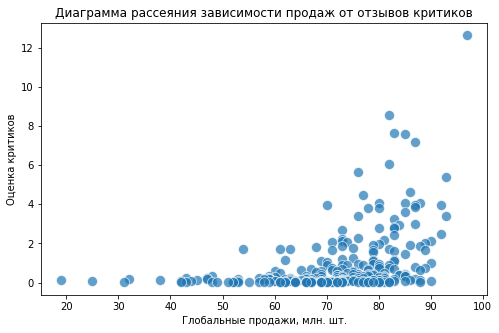

----------------------------------------------------------------------------------------


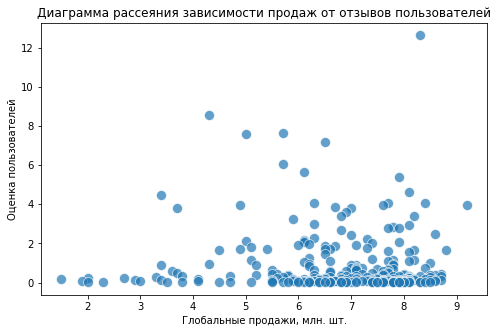

In [25]:
scatter_maker(df_PS4, 'critic_score', 'total_sales', 
              'Диаграмма рассеяния зависимости продаж от отзывов критиков', 
              'Глобальные продажи, млн. шт.', 'Оценка критиков')
print('----------------------------------------------------------------------------------------')
scatter_maker(df_PS4, 'user_score', 'total_sales',
              'Диаграмма рассеяния зависимости продаж от отзывов пользователей', 
              'Глобальные продажи, млн. шт.', 'Оценка пользователей')

- между глобальными продажами и отзывами критиков есть прямая зависимость средней силы.  
- между глобальными продажами и отзывами пользователей зависимость практически отсутствует (крайне слабая обратная зависимость).

In [26]:
correlation(new_df.query('platform == "XOne"'), 'total_sales', 'critic_score', 'продажами XOne и отзывами критиков')
correlation(new_df.query('platform == "XOne"'), 'total_sales', 'user_score', 'продажами XOne и отзывами пользователей')

Коэффициент корреляции между продажами XOne и отзывами критиков : 0.417
Коэффициент корреляции между продажами XOne и отзывами пользователей : -0.069


для платформы XOne зависимости близки к зависимостям PS4. Для XOne зависимость между продажами и отзывами пользователей немного сильнее чем для PS4, но все равно очень слабая обратная.

### распределение игр по жанрам

построим диаграмму рассеяния по количеству игр в жанрах и мелианными объемами продаж

In [27]:
#new_df.head()

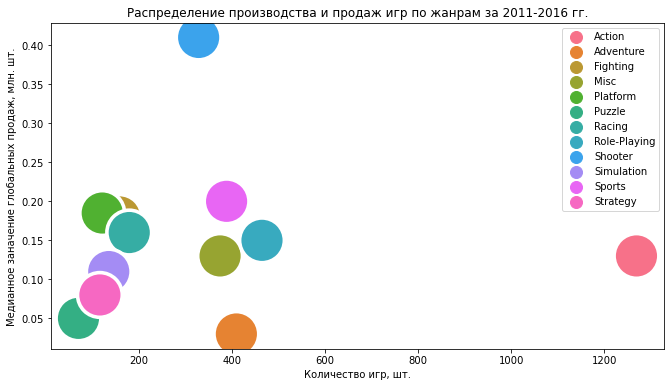

In [28]:
pivot_genres=new_df.groupby('genre').agg({'total_sales':'median', 'name':'count', 'total_sales':'median'}) 
#pivot_genres

f, ax = plt.subplots(figsize=(11, 6))
sns.scatterplot(
    data=pivot_genres,
    x="name", 
    y="total_sales",
    hue="genre", s=2000)
plt.legend(loc=1, fontsize='medium', markerscale=2)
plt.xlabel('Количество игр, шт.')
plt.ylabel('Медианное заначение глобальных продаж, млн. шт.')
plt.title('Распределение производства и продаж игр по жанрам за 2011-2016 гг.')
plt.show()

- высокими продажами отличаются также жанр shooter.
- низкие продажи в жанрах:adventure, strategy, puzzle.


- наибольшее число игр представлено жанрами: action.
- реже всего встречаются жанры: puzzle, platform, strategy и fighting, simulation.

стоит обратить внимание на жанр Action, он представлен больши количеством игр, но медианные продажи по нему крайне малы, стоило бы выяснить причину такой непопулярности.

### Промежуточный вывод

большинство платформ используются ~ 10 лет, следовательно актуальными можно считать данные за последние 5 лет. в среднем, каждые 5 лет появляется новая платформа.
- **лидеры продаж** за последние 5 лет: PS3, X360, PS4, 3DS, XOne.
- **потенциально прибыльными** являются платформы *PS4 и XOne*, они - новые поколения самых прибых за последие 5 лет платформ, и продажи по ним растут. 
- Xbox платформы превышают по медианному объему PS платформы, однако если PS3 уступает X360 по объему продаж, то PS4 немного превосходит XOne и даже конкурирует с X360.
- присутствует значительное число выбросов, особенно по платформам 3DS, что может быть обусловленно выходом какой-нибудь популярной игры. 

- между глобальными продажами и отзывами критиков есть *прямая зависимость средней силы* (0.407 для PS4).
- между глобальными продажами и отзывами пользователей *зависимость практически отсутствует*(-0.037 для PS4).

**распределение игр и продаж по жанрам:**
- высокими продажами отличаются также жанр shooter.
- низкие продажи в жанрах:adventure, strategy, puzzle.

- наибольшее число игр представлено жанрами: action.
- реже всего встречаются жанры: puzzle, platform, strategy и fighting, simulation.

**Рекомендация:**
стоит обратить внимание на жанр Action, он представлен больши количеством игр, но медианные продажи по нему крайне малы, стоило бы выяснить причину такой непопулярности.

## Портрет пользователя каждого региона

### ТОП-5 платформ по продажам в каждом регионе

создадим функицию которая считает доли категории по какому-либо столбцу.

In [29]:
def percent_df(df, criteria, region, xlabel, ylabel, title):
    pivot=df.pivot_table(index=criteria,       # строим сводную таблицу 
                         values=region, 
                         aggfunc='sum').sort_values(by=region, ascending=False).reset_index()
    total=0
    for i in df[region]:
        total+=i
        pivot['total']=total
    pivot['percentage']=round(pivot[region]/pivot['total']*100, 2)  # считаем доли 
    pivot=pivot.loc[:4]
    pivot['percentage']=pivot['percentage']
    display(pivot)
    
    plt.figure(figsize=(8, 4))
    sns.barplot(data=pivot, x=criteria, y='percentage', palette="rocket")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title('ТОП-5 '+ title + ' по объему продаж за 2011-2016 гг.')
    plt.show()
    print('-------------------------------------------------------------------------')

,platform,na_sales,total,percentage
0,X360,226.80,829.76,27.33
1,PS3,168.26,829.76,20.28
2,PS4,108.74,829.76,13.10
3,XOne,93.12,829.76,11.22
4,3DS,82.65,829.76,9.96


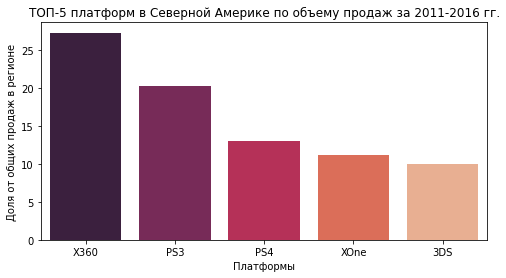

-------------------------------------------------------------------------


,platform,eu_sales,total,percentage
0,PS3,163.10,669.79,24.35
1,PS4,141.09,669.79,21.06
2,X360,117.10,669.79,17.48
3,3DS,61.27,669.79,9.15
4,PC,56.70,669.79,8.47


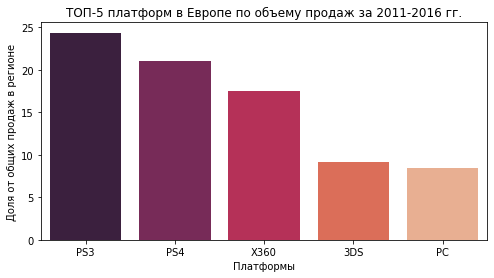

-------------------------------------------------------------------------


,platform,jp_sales,total,percentage
0,3DS,100.62,245.65,40.96
1,PS3,49.39,245.65,20.11
2,PSP,24.04,245.65,9.79
3,PSV,21.84,245.65,8.89
4,PS4,15.96,245.65,6.50


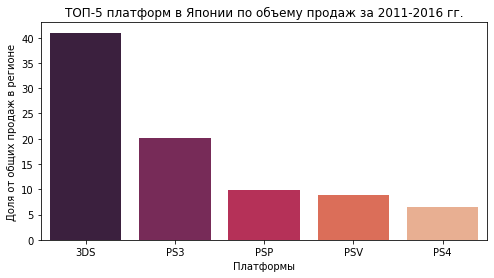

-------------------------------------------------------------------------


,platform,other_sales,total,percentage
0,PS3,64.82,208.91,31.03
1,PS4,48.35,208.91,23.14
2,X360,33.13,208.91,15.86
3,XOne,14.27,208.91,6.83
4,3DS,13.27,208.91,6.35


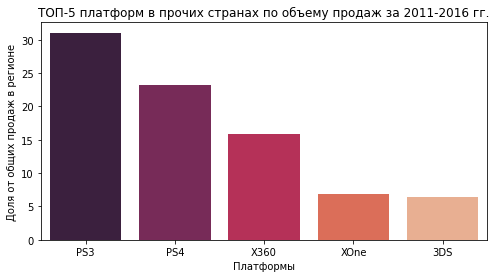

-------------------------------------------------------------------------


In [30]:
percent_df(new_df, 'platform', 'na_sales', 'Платформы', 'Доля от общих продаж в регионе', 'платформ в Северной Америке')
percent_df(new_df, 'platform', 'eu_sales', 'Платформы', 'Доля от общих продаж в регионе', 'платформ в Европе')
percent_df(new_df, 'platform', 'jp_sales', 'Платформы', 'Доля от общих продаж в регионе', 'платформ в Японии')
percent_df(new_df, 'platform', 'other_sales', 'Платформы', 'Доля от общих продаж в регионе', 'платформ в прочих странах')

- в Северной Америке самые популярные платформы: X360 (27.3%), PS3 (20.3%), PS4 (13.1%);
- в Европе: PS3 (24.4%), PS4 (21.1%), X360 (17.5%);
- в Японии: 3DS (41.0%), PS3 (20.1%), PSP (9.8%);
- в прочих странах: PS3 (31.0%), PS4 (23.1%), X360 (15.9%).

популярные платформы в Японии сильно отличаются от платформ в других странах. продажи игр для 3DS в Японии на 31% больше чем в Северной Америке или на 31.9% больше чем в Европе. 3DS присутствует в ТОПе только в Японии, в остальных странах не пользуется популярностью.

PS3 популярна во всех регионах кроме прочих стран (31%) примерно в равных пропорциях (от 20.3% до 24.4%)

в Северной Америке X360 - лидер продаж (27.3%), что на 9.8% больше чем в Европе и на 11.4% больше чем в прочих странах. в Японии эта платформа не вошла в ТОП.

ТОП в Европе и прочих странах схож, разница в долях не превышает 3.5%. единственное отличие предпочтений в этих регионах в том, что в Европе в ТОП вошел PC (8.5%), а в прочих странах XOne (6.8%).

### ТОП-5 популярных жанров

,genre,na_sales,total,percentage
0,Action,230.92,829.76,27.83
1,Shooter,194.43,829.76,23.43
2,Sports,108.70,829.76,13.10
3,Role-Playing,83.78,829.76,10.10
4,Misc,69.69,829.76,8.40


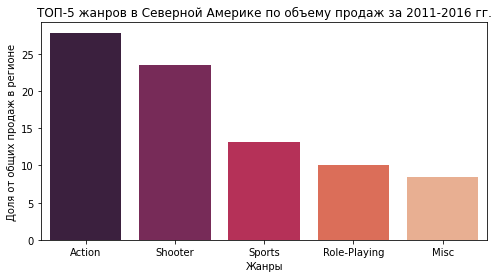

-------------------------------------------------------------------------


,genre,eu_sales,total,percentage
0,Action,199.12,669.79,29.73
1,Shooter,148.02,669.79,22.10
2,Sports,88.48,669.79,13.21
3,Role-Playing,62.30,669.79,9.30
4,Racing,40.58,669.79,6.06


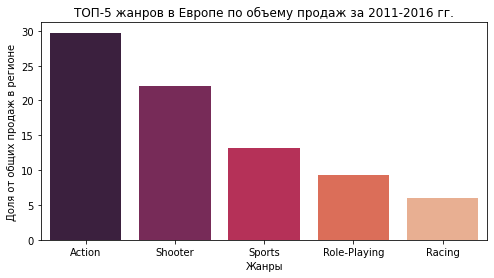

-------------------------------------------------------------------------


,genre,jp_sales,total,percentage
0,Role-Playing,79.87,245.65,32.51
1,Action,63.62,245.65,25.90
2,Misc,17.60,245.65,7.16
3,Fighting,12.38,245.65,5.04
4,Platform,12.13,245.65,4.94


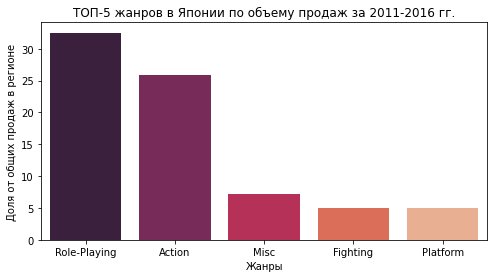

-------------------------------------------------------------------------


,genre,other_sales,total,percentage
0,Action,64.14,208.91,30.70
1,Shooter,48.54,208.91,23.23
2,Sports,28.88,208.91,13.82
3,Role-Playing,19.68,208.91,9.42
4,Misc,12.41,208.91,5.94


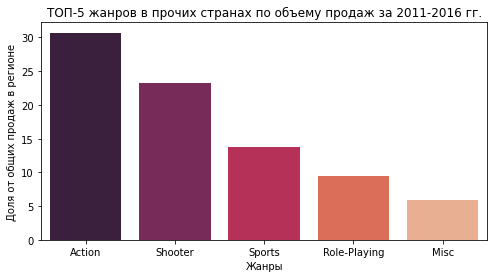

-------------------------------------------------------------------------


In [31]:
percent_df(new_df, 'genre', 'na_sales', 'Жанры', 'Доля от общих продаж в регионе', 'жанров в Северной Америке')
percent_df(new_df, 'genre', 'eu_sales', 'Жанры', 'Доля от общих продаж в регионе', 'жанров в Европе')
percent_df(new_df, 'genre', 'jp_sales', 'Жанры', 'Доля от общих продаж в регионе', 'жанров в Японии')
percent_df(new_df, 'genre', 'other_sales', 'Жанры', 'Доля от общих продаж в регионе', 'жанров в прочих странах')

- в Северной Америке самые популярные жанры: Action (27.9%), Shooter (23.4%), Sports (13.1%);
- в Европе: Action (29.7%), Shooter (22.1%), Sports (13.2%);
- в Японии: Role-Playing (32.5%), Action (25.9%), Misc (7.2%);
- в прочих странах: Action (30.7%), Shooter (23.2%), Sports (13.8%).

ТОП жанров в Японии кардинально отличается от жанров в других регионах более 58% продаж приходится на 2 жанра (Role-Playing и Action). доля Role-Playing на 22.4% превышает долю этого жанра в Северной Америке, и на 23.2% чем в Европе. следом идет Action, который немного менее популярен, чем в других регионах.

популярные жанры в Северной Америке и прочих странах совпадают. ТОП для Европы практически полностью совпадает с ТОПами в Северной Америке и прочих странах, только вместо Misc на 5 месте с долей 6.1% располагается жанр Racing.

### влияние рейтинга ESRB на продажи в регионах

рассчитаем коэффициенты корреляции между рейтингом ESRB и продажами в регионах

In [32]:
correlation(new_df, 'total_sales', 'na_sales', 'рейтингом ESRB и продажами в Северной Америке')
correlation(new_df, 'total_sales', 'eu_sales', 'рейтингом ESRB и продажами в Европе')
correlation(new_df, 'total_sales', 'jp_sales', 'рейтингом ESRB и продажами в Японии')
correlation(new_df, 'total_sales', 'other_sales', 'рейтингом ESRB и продажами в прочих странах')

Коэффициент корреляции между рейтингом ESRB и продажами в Северной Америке : 0.928
Коэффициент корреляции между рейтингом ESRB и продажами в Европе : 0.931
Коэффициент корреляции между рейтингом ESRB и продажами в Японии : 0.447
Коэффициент корреляции между рейтингом ESRB и продажами в прочих странах : 0.915


- существует сильная зависимость между рейтингом и продажами в Северной Америке и Европе (0.93), незначительно слабее зависимость в прочих странах (0.92).
- в Японии зависимость средней силы (0.45)

In [33]:
#функция считающая долю
values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
def percent(df, col, new_col):
    total=0
    for i in df[col]:
        total+=i
        df['total']=total
        df[new_col]=round(df[col]/df['total']*100, 2)

создадим таблицу с долями в продажах по каждой игре

In [34]:
percent(new_df, 'na_sales', 'percent_na')
percent(new_df, 'eu_sales', 'percent_eu')
percent(new_df, 'jp_sales', 'percent_jp')
percent(new_df, 'other_sales', 'percent_other')
new_df.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,total,percent_na,percent_eu,percent_jp,percent_other
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05,208.91,0.85,1.36,0.40,1.90
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27,208.91,1.16,0.77,0.02,0.67


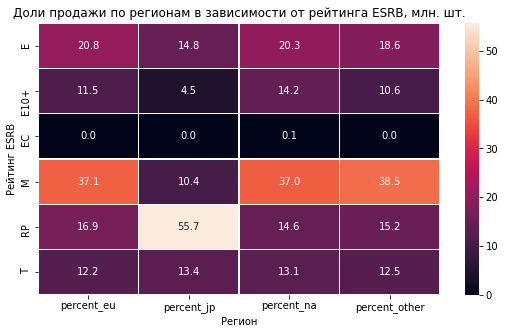

In [35]:
ESRB=new_df.pivot_table(index='rating', values=['percent_na', 'percent_eu', 'percent_jp', 'percent_other'], aggfunc='sum')

f, ax=plt.subplots(figsize=(9, 5))
sns.heatmap(ESRB, annot=True, fmt='.1f', linewidths=.5)
plt.xlabel('Регион')
plt.ylabel('Рейтинг ESRB')
plt.title('Доли продажи по регионам в зависимости от рейтинга ESRB, млн. шт.')
plt.show()

- во всех регионах кроме Японии распределение долей продаж в зависимости от рейтинга ESRB схоже.
- везде плохо продаются игры с рейтингом EC.
- в Японии особой популярностью пользуются игры с рейтингов RP (рейтинг ожидается). Возможно там особенно популярны новинки.

### Промежуточный вывод

**ТОП платформ**
- в Северной Америке самые популярные платформы: X360 (27.3%), PS3 (20.3%), PS4 (13.1%);
- в Европе: PS3 (24.4%), PS4 (21.1%), X360 (17.5%);
- в Японии: 3DS (41.0%), PS3 (20.1%), PSP (9.8%);
- в прочих странах: PS3 (31.0%), PS4 (23.1%), X360 (15.9%).

популярные платформы в Японии сильно отличаются от платформ в других странах. продажи игр для 3DS в Японии на 31% больше чем в Северной Америке или на 31.9% больше чем в Европе. 3DS присутствует в ТОПе только в Японии, в остальных странах не пользуется популярностью.

PS3 популярна во всех регионах кроме прочих стран (31%) примерно в равных пропорциях (от 20.3% до 24.4%)

ТОП в Европе и прочих странах схож, разница в долях не превышает 3.5%. единственное отличие предпочтений в этих регионах в том, что в Европе в ТОП вошел PC (8.5%), а в прочих странах XOne (6.8%).

**ТОП жанров**

- в Северной Америке самые популярные жанры: Action (27.9%), Shooter (23.4%), Sports (13.1%);
- в Европе: Action (29.7%), Shooter (22.1%), Sports (13.2%);
- в Японии: Role-Playing (32.5%), Action (25.9%), Misc (7.2%);
- в прочих странах: Action (30.7%), Shooter (23.2%), Sports (13.8%).

ТОП жанров в Японии кардинально отличается от жанров в других регионах более 58% продаж приходится на 2 жанра (Role-Playing и Action). доля Role-Playing на 22.4% превышает долю этого жанра в Северной Америке, и на 23.2% чем в Европе. следом идет Action, который немного менее популярен, чем в других регионах.

популярные жанры в Северной Америке и прочих странах совпадают. ТОП для Европы практически полностью совпадает с ТОПами в Северной Америке и прочих странах, только вместо Misc на 5 месте с долей 6.1% располагается жанр Racing.

**зависимость между рейтингом ESRB и продажами в регионах** 
- существует сильная зависимость между рейтингом и продажами в Северной Америке и Европе (0.93), незначительно слабее зависимость в прочих странах (0.92).
- в Японии зависимость средней силы (0.45)

- во всех регионах кроме Японии распределение долей продаж в зависимости от рейтинга ESRB схоже.
- везде плохо продаются игры с рейтингом EC.
- в Японии особой популярностью пользуются игры с рейтингов RP (рейтинг ожидается). Возможно там особенно популярны новинки.

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Н0: Средние пользовательские рейтинги платформ Xbox One и PC равны.

Н1: Средние пользовательские рейтинги платформ Xbox One и PC не равны.

создадим датафреймы с данными про Xbox one и PC

In [36]:
XOne=new_df.loc[new_df['platform']=='XOne']
PC=new_df.loc[new_df['platform']=='PC']

print('число строк XOne:', XOne.shape[0])
print('число строк PC:', PC.shape[0])

#сделаем таблицы одинакового размера
PC=PC.sample(len(XOne))
print('новое число строк PC:', PC.shape[0])

число строк XOne: 247
число строк PC: 389
новое число строк PC: 247


удалим пропуски

In [37]:
XOne.dropna(subset=['user_score'], inplace=True)
#XOne.info()

PC.dropna(subset=['user_score'], inplace=True)
#PC.info()

проверим распределение на нормальность

In [38]:
def norm_check(df, col):    # фуенкция строящая qqplot
    qqplot(df[col], line='s')
    plt.title('Близость к нормальному распределению (красная линия)')
    plt.show()

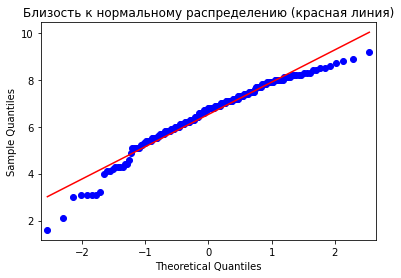

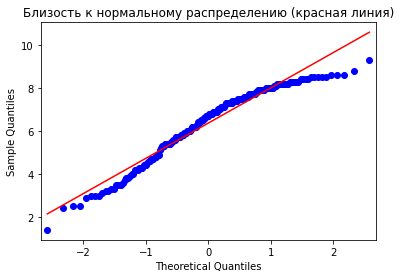

In [39]:
norm_check(XOne, 'user_score')
norm_check(PC, 'user_score')

распределения выборок сильно отклюняются от нормального

определим отличаются ли дисперсии выборок

In [40]:
def var_difference(df1, df2, col): # функция определяющая различаются ли дисперсии
    var1=np.var(df1[col], ddof=1)
    var2=np.var(df2[col], ddof=1)
    if var1/var2*100-100 > 5:      # если разница более 5% то дисперсии разичны
        print('дисперсии различны')
    elif var2/var1*100-100 > 5: 
        print('дисперсии различны')
    else:
        print('дисперсии равны')

In [41]:
var_difference(XOne, PC, 'user_score')

дисперсии различны


проверим гипотезы критерием Манна-Уитни, т.к. он позволяет отказаться от предположения нормальности распределения и одинаковых дисперсий.

In [42]:
alpha=0.05
results=st.mannwhitneyu(XOne['user_score'], PC['user_score'], alternative='two-sided')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('гипотеза Н0 отвергается, средние пользовательские рейтинги платформ Xbox One и PC не равны')
else:
    print('гипотеза Н0 принимается, средние пользовательские рейтинги платформ Xbox One и PC равны')

p-значение: 0.7415629500039522
гипотеза Н0 принимается, средние пользовательские рейтинги платформ Xbox One и PC равны


р-значение очень велико, что позволяет принять нулевую гипотезу

### Средние пользовательские рейтинги жанров Action и Sports разные.

HO: Средние пользовательские рейтинги жанров Action и Sports равны.

Н1: Средние пользовательские рейтинги жанров Action и Sports различаются.

In [43]:
Action=new_df.loc[new_df['genre']=='Action']
Sports=new_df.loc[new_df['genre']=='Sports']

print('число строк Action:', Action.shape[0])
print('число строк Sports:', Sports.shape[0])

#сделаем таблицы одинакового размера
Action=Action.sample(len(Sports))
print('новое число строк PC:', Action.shape[0])

число строк Action: 1269
число строк Sports: 389
новое число строк PC: 389


удалим пропуски

In [44]:
Action.dropna(subset=['user_score'], inplace=True)
#Action.info()

Sports.dropna(subset=['user_score'], inplace=True)
#Sports.info()

проверим распределения выборок на нормальность

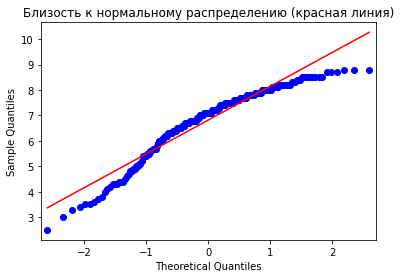

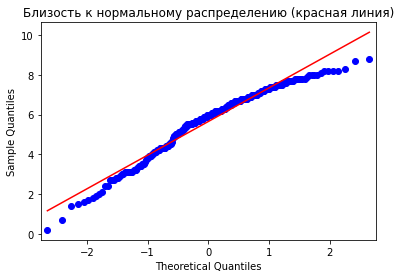

In [45]:
norm_check(Action, 'user_score')
norm_check(Sports, 'user_score')

рассчитаем дисперсии выборок

In [46]:
var_difference(Action, Sports, 'user_score')

дисперсии различны


проверим гипотезы критерием Стьюдента

In [47]:
alpha=0.05
results=st.ttest_ind(Action['user_score'], Sports['user_score'], equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('гипотеза Н0 отвергается, средние пользовательские рейтинги жанров Action и Sports не равны')
else:
    print('гипотеза Н0 принимается, средние пользовательские рейтинги жанров Action и Sports равны')

p-значение: 1.8284749647763585e-15
гипотеза Н0 отвергается, средние пользовательские рейтинги жанров Action и Sports не равны


для alpha = 0.05 гипотеза Н0 отвергается. т.к. p-значение ничтожно мало, можно не перепроверять методом Манна-Уитни.

### Промежуточный вывод

для alpha = 0.05 гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC принимается, т.к. р-значение очень велико.
гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports отвергается, рейтинги отличаются.

## Общий вывод

В нашем распоряжении данные по продажам компьютерных игр за 1980-2016 гг. с данными о 16715 играх.

- обнаружено много нулевых значений в столбцах с продажами. скорее всего из-за того, что продаж было мало, а в таблице они измеряются в млн.
- tbd в пользовательском рейтинге заполнены медианным значением по жанру.
- пропуски в рейтинге ESRB заполнены "RP" (рейтинг ожидается).

большинство платформ используются ~ 10 лет, следовательно актуальными можно считать данные за последние 5 лет. в среднем, каждые 5 лет появляется новая платформа.
- **лидеры продаж** за последние 5 лет: PS3, X360, PS4, 3DS, XOne.
- **потенциально прибыльными** являются платформы *PS4 и XOne*, они - новые поколения самых прибых за последие 5 лет платформ, и продажи по ним растут. 
- Xbox платформы превышают по медианному объему PS платформы, однако если PS3 уступает X360 по объему продаж, то PS4 немного превосходит XOne и даже конкурирует с X360.
- присутствует значительное число выбросов, особенно по платформам 3DS, что может быть обусловленно выходом какой-нибудь популярной игры. 

- между глобальными продажами и отзывами критиков есть *прямая зависимость средней силы* (0.407 для PS4).
- между глобальными продажами и отзывами пользователей *зависимость практически отсутствует*(-0.037 для PS4).

**распределение игр и продаж по жанрам:**
- высокими продажами отличаются также жанр shooter.
- низкие продажи в жанрах:adventure, strategy, puzzle.

- наибольшее число игр представлено жанрами: action.
- реже всего встречаются жанры: puzzle, platform, strategy и fighting, simulation.

**Рекомендация:**
стоит обратить внимание на жанр Action, он представлен больши количеством игр, но медианные продажи по нему крайне малы, стоило бы выяснить причину такой непопулярности.

**ТОП платформ**
- в Северной Америке самые популярные платформы: X360 (27.3%), PS3 (20.3%), PS4 (13.1%);
- в Европе: PS3 (24.4%), PS4 (21.1%), X360 (17.5%);
- в Японии: 3DS (41.0%), PS3 (20.1%), PSP (9.8%);
- в прочих странах: PS3 (31.0%), PS4 (23.1%), X360 (15.9%).

популярные платформы в Японии сильно отличаются от платформ в других странах. продажи игр для 3DS в Японии на 31% больше чем в Северной Америке или на 31.9% больше чем в Европе. 3DS присутствует в ТОПе только в Японии, в остальных странах не пользуется популярностью.

PS3 популярна во всех регионах кроме прочих стран (31%) примерно в равных пропорциях (от 20.3% до 24.4%)

ТОП в Европе и прочих странах схож, разница в долях не превышает 3.5%. единственное отличие предпочтений в этих регионах в том, что в Европе в ТОП вошел PC (8.5%), а в прочих странах XOne (6.8%).

**ТОП жанров**

- в Северной Америке самые популярные жанры: Action (27.9%), Shooter (23.4%), Sports (13.1%);
- в Европе: Action (29.7%), Shooter (22.1%), Sports (13.2%);
- в Японии: Role-Playing (32.5%), Action (25.9%), Misc (7.2%);
- в прочих странах: Action (30.7%), Shooter (23.2%), Sports (13.8%).

ТОП жанров в Японии кардинально отличается от жанров в других регионах более 58% продаж приходится на 2 жанра (Role-Playing и Action). доля Role-Playing на 22.4% превышает долю этого жанра в Северной Америке, и на 23.2% чем в Европе. следом идет Action, который немного менее популярен, чем в других регионах.

популярные жанры в Северной Америке и прочих странах совпадают. ТОП для Европы практически полностью совпадает с ТОПами в Северной Америке и прочих странах, только вместо Misc на 5 месте с долей 6.1% располагается жанр Racing.

**зависимость между рейтингом ESRB и продажами в регионах** 
- существует сильная зависимость между рейтингом и продажами в Северной Америке и Европе (0.93), незначительно слабее зависимость в прочих странах (0.92).
- в Японии зависимость средней силы (0.45)

- во всех регионах кроме Японии распределение долей продаж в зависимости от рейтинга ESRB схоже.
- везде плохо продаются игры с рейтингом EC.
- в Японии особой популярностью пользуются игры с рейтингов RP (рейтинг ожидается). Возможно там особенно популярны новинки.

**результаты проверки гипотез**
- гипотеза о равенстве средних пользовательских рейтингов платформ Xbox One и PC принимается, т.к. р-значение очень велико. 
- гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports отвергается, рейтинги отличаются

- [x] данные открыты и изучены.
- [x] названия столбцов приведены к нижнему регистру;
- [x] Преобразованы типы данных;
- [x] Обработаны пропуски при необходимости;
- [x] Описаны причины, которые могли привести к пропускам;
- [x] Описано, как обработать аббревиатуру 'tbd' в столбцах с рейтингом и обработано;
- [x] Посчитаны суммарные продажи во всех регионах и записаны в отдельный столбец.
- [x] составлено распределение выпуска игр в разные годы. определена важность периодов.
- [x] изучено как менялись продажи по платформам. Выбраны платформы с наибольшими суммарными продажами и построено распределение по годам. определено за какой характерный срок появляются новые и исчезают старые платформы.
- [x] Возьмите данные за соответствующий актуальный период. 
- [x] определено какие платформы лидируют по продажам, растут или падают. Выбраны несколько потенциально прибыльных платформ.
- [x] Построен график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Описан результат.
- [x] выявлено влияние на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построена диаграмма рассеяния и посчитана корреляция между отзывами и продажами.
- [x] Соотнесены выводы с продажами игр на других платформах.
- [x] изучено общее распределение игр по жанрам. оперделено выделяются ли жанры с высокими и низкими продажами.
- Определены для пользователя каждого региона (NA, EU, JP):
- [x] Самые популярные платформы (топ-5). Описаны различия в долях продаж.
- [x] Самые популярные жанры (топ-5). объяснена разница.
- [x] определено влияет ли рейтинг ESRB на продажи в отдельном регионе.
- Проверены гипотезы:
- [x] Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- [x] Средние пользовательские рейтинги жанров Action и Sports разные.
- [x] Написан общий вывод